In [95]:
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, r2_score

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os

In [96]:
train = pd.read_csv('dataset/train.csv')
test= pd.read_csv('dataset/test.csv')
wind = 'windmill_generated_power(kW/h)'
train.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


In [97]:
train.dtypes

tracking_id                        object
datetime                           object
wind_speed(m/s)                   float64
atmospheric_temperature(°C)       float64
shaft_temperature(°C)             float64
blades_angle(°)                   float64
gearbox_temperature(°C)           float64
engine_temperature(°C)            float64
motor_torque(N-m)                 float64
generator_temperature(°C)         float64
atmospheric_pressure(Pascal)      float64
area_temperature(°C)              float64
windmill_body_temperature(°C)     float64
wind_direction(°)                 float64
resistance(ohm)                   float64
rotor_torque(N-m)                 float64
turbine_status                     object
cloud_level                        object
blade_length(m)                   float64
blade_breadth(m)                  float64
windmill_height(m)                float64
windmill_generated_power(kW/h)    float64
dtype: object

# Deal with NaN Values:

In [98]:
train.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64

### Remove rows with Null Targets

In [99]:
train = train[~train[wind].isnull()]
train.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    271
atmospheric_temperature(°C)       3422
shaft_temperature(°C)                2
blades_angle(°)                    212
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2690
area_temperature(°C)                 0
windmill_body_temperature(°C)     2352
wind_direction(°)                 5058
resistance(ohm)                      1
rotor_torque(N-m)                  567
turbine_status                    1747
cloud_level                        272
blade_length(m)                   5057
blade_breadth(m)                     0
windmill_height(m)                 538
windmill_generated_power(kW/h)       0
dtype: int64

## Split before filling

In [100]:
from sklearn.model_selection import train_test_split
X = train.drop([wind, 'tracking_id', 'datetime'], axis=1)
y = train[wind]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 0)

X_train.shape, X_test.shape

((27713, 19), (280, 19))

### Categorical Features

In [101]:
# Function to impute most occured category and add importance vairable
def impute_categorical(DataFrame,ColName):
    #1. add new column and replace if category is null then 1 else 0
    DataFrame[ColName+"_Imputed"] =   np.where(DataFrame[ColName].isnull(),1,0)
    
    # 2. Take most occured category in that variable (.mode())
    Mode_Category = DataFrame[ColName].mode()[0]
    
    ## 2.1 Replace NAN values with most occured category in actual variable
    DataFrame[ColName].fillna(Mode_Category,inplace=True)

In [102]:
splited = [X_train, X_test]
for s in splited:
    for c in ['turbine_status','cloud_level']:
        impute_categorical(s, c)
    
# train[['turbine_status','turbine_status_Imputed','cloud_level','cloud_level_Imputed']].head(10)

### Numerical

In [103]:
X_train.columns

Index(['wind_speed(m/s)', 'atmospheric_temperature(°C)',
       'shaft_temperature(°C)', 'blades_angle(°)', 'gearbox_temperature(°C)',
       'engine_temperature(°C)', 'motor_torque(N-m)',
       'generator_temperature(°C)', 'atmospheric_pressure(Pascal)',
       'area_temperature(°C)', 'windmill_body_temperature(°C)',
       'wind_direction(°)', 'resistance(ohm)', 'rotor_torque(N-m)',
       'turbine_status', 'cloud_level', 'blade_length(m)', 'blade_breadth(m)',
       'windmill_height(m)', 'turbine_status_Imputed', 'cloud_level_Imputed'],
      dtype='object')

In [105]:
for s in splited:
    for i in s.columns:
        if s[i].isnull().sum()>0:
            mean = s[i].mean()
            s[i].replace(np.nan, mean, inplace=True)

In [106]:
X_train.shape

(27713, 21)

In [107]:
X_test.isnull().sum()

wind_speed(m/s)                  0
atmospheric_temperature(°C)      0
shaft_temperature(°C)            0
blades_angle(°)                  0
gearbox_temperature(°C)          0
engine_temperature(°C)           0
motor_torque(N-m)                0
generator_temperature(°C)        0
atmospheric_pressure(Pascal)     0
area_temperature(°C)             0
windmill_body_temperature(°C)    0
wind_direction(°)                0
resistance(ohm)                  0
rotor_torque(N-m)                0
turbine_status                   0
cloud_level                      0
blade_length(m)                  0
blade_breadth(m)                 0
windmill_height(m)               0
turbine_status_Imputed           0
cloud_level_Imputed              0
dtype: int64

In [108]:
X_train.shape, X_test.shape

((27713, 21), (280, 21))

## Merge and keep for later use

In [109]:
train2 = pd.concat([X_train, X_test], axis = 0, ignore_index=True)
targ = pd.concat([y_train, y_test], axis = 0, ignore_index=True)
train3 = pd.concat([train2, targ], axis = 1)
# for i in range(len(train3.columns) - 1):
#     train3.rename(columns = {train3.columns[i] : train3.columns[i][0]}, inplace = True)
train3

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed,windmill_generated_power(kW/h)
0,29.165222,4.441551,16.007962,-1.158862,116.522664,18.559412,881.213471,41.487133,116942.259539,25.369996,11.626132,280.130198,1340.359899,14.684567,BB,Medium,4.546609,0.432503,24.812621,1,0,7.095428
1,94.767684,18.081439,43.793750,86.947450,41.008143,41.297332,1004.433697,66.353153,16311.985415,29.326023,-99.000000,374.388573,1663.337042,25.834748,D,Extremely Low,2.244555,0.237205,16.311905,0,0,1.754915
2,39.097877,8.921827,46.758274,-99.000000,46.641045,45.137630,957.009470,42.448288,129052.691467,32.356140,20.754016,342.613137,1427.354328,15.268205,BB,Low,-99.000000,0.467374,24.622301,0,0,8.545864
3,18.387458,9.926404,45.314961,-1.133298,44.719208,42.654147,772.373345,39.778793,122655.688822,25.268513,40.085835,275.660822,1240.895255,14.519918,BA,Medium,3.455391,0.449980,26.400075,0,0,5.771535
4,94.476735,26.159988,11.460848,39.749659,-2.088118,44.298081,1117.198016,69.563057,16621.749862,30.321309,43.924408,306.648593,1663.405530,22.596888,AC,Medium,4.337868,0.437560,24.375441,0,0,2.967410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27988,205.877463,-99.000000,42.531312,40.968971,41.649804,42.760867,526.074933,37.237309,114030.753556,28.213448,44.359178,225.944824,1163.440984,-115.027862,B,Medium,3.794529,0.422523,27.751522,0,0,2.871340
27989,93.643656,33.617309,44.013938,0.762278,96.679473,41.453165,2147.446711,70.476839,17116.015118,39.558442,43.008021,276.515502,1694.718170,35.347647,AB,Medium,2.211411,0.308142,25.564309,0,0,4.076780
27990,380.229029,11.722376,43.053466,1.296582,44.788704,44.095178,756.766063,44.522909,77291.728212,29.924312,41.201989,55.865086,1188.992564,12.233934,ABC,Low,4.139110,0.467881,26.306664,0,0,3.867239
27991,-54.252314,18.640625,41.057651,21.337316,87.649093,42.133972,1531.646898,70.317959,16963.206456,30.778969,41.406119,260.133656,1666.794453,27.841929,B,Low,4.332921,0.361095,25.050941,0,0,2.749711


## Distribution

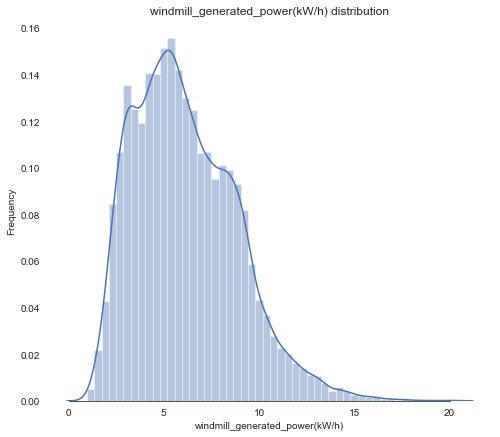

In [110]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train3[wind], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel=wind)
ax.set(title=f"{wind} distribution")
sns.despine(trim=True, left=True)
plt.show()

In [111]:
# # log(1+x) transform
# train3[wind] = np.log1p(train3[wind])

# sns.set_style("white")
# sns.set_color_codes(palette='deep')
# f, ax = plt.subplots(figsize=(8, 7))
# #Check the new distribution 
# sns.distplot(train3[wind] , fit=norm, color="b");

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train3[wind])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# #Now plot the distribution
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# ax.xaxis.grid(False)
# ax.set(ylabel="Frequency")
# ax.set(xlabel=wind)
# ax.set(title=f"{wind} distribution")
# sns.despine(trim=True, left=True)

# plt.show()

In [112]:
y_train

20639     7.095428
505       1.754915
18039     8.545864
16785     5.771535
24401     2.967410
           ...    
13210     8.626782
19784    11.251304
9910     12.843119
10869     2.751944
2749      8.384875
Name: windmill_generated_power(kW/h), Length: 27713, dtype: float64

## Outliers

In [144]:
def cap_data(df):
    for col in df.columns:
        if (df[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']) and (col != wind):
            print("capping the ",col)
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

train3 = cap_data(train3)
train3

capping the  wind_speed(m/s)
capping the  atmospheric_temperature(°C)
capping the  shaft_temperature(°C)
capping the  blades_angle(°)
capping the  gearbox_temperature(°C)
capping the  engine_temperature(°C)
capping the  motor_torque(N-m)
capping the  generator_temperature(°C)
capping the  atmospheric_pressure(Pascal)
capping the  area_temperature(°C)
capping the  windmill_body_temperature(°C)
capping the  wind_direction(°)
capping the  resistance(ohm)
capping the  rotor_torque(N-m)
capping the  blade_length(m)
capping the  blade_breadth(m)
capping the  windmill_height(m)
capping the  turbine_status_Imputed
capping the  cloud_level_Imputed


,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed,windmill_generated_power(kW/h)
0,29.165222,4.441551,16.007962,-1.158862,116.522664,18.559412,881.213471,41.487133,116942.259539,25.369996,11.626132,280.130198,1340.359899,14.684567,BB,Medium,4.546609,0.432503,24.812621,1,0,7.095428
1,94.767684,18.081439,43.793750,86.947450,41.008143,41.297332,1004.433697,66.353153,16311.985415,29.326023,-99.000000,374.388573,1663.337042,25.834748,D,Extremely Low,2.244555,0.248107,16.311905,0,0,1.754915
2,39.097877,8.921827,46.758274,-99.000000,46.641045,45.137630,957.009470,42.448288,129052.691467,32.356140,20.754016,342.613137,1427.354328,15.268205,BB,Low,-7.107521,0.467374,24.622301,0,0,8.545864
3,18.387458,9.926404,45.314961,-1.133298,44.719208,42.654147,772.373345,39.778793,122655.688822,25.268513,40.085835,275.660822,1240.895255,14.519918,BA,Medium,3.455391,0.449980,26.400075,0,0,5.771535
4,94.476735,26.159988,11.460848,39.749659,-2.088118,44.298081,1117.198016,69.563057,16621.749862,30.321309,43.924408,306.648593,1663.405530,22.596888,AC,Medium,4.337868,0.437560,24.375441,0,0,2.967410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27988,205.877463,-99.000000,42.531312,40.968971,41.649804,42.760867,526.074933,37.237309,114030.753556,28.213448,44.359178,225.944824,1163.440984,-99.000000,B,Medium,3.794529,0.422523,27.751522,0,0,2.871340
27989,93.643656,33.617309,44.013938,0.762278,96.679473,41.453165,2147.446711,70.476839,17116.015118,39.558442,43.008021,276.515502,1694.718170,35.347647,AB,Medium,2.211411,0.308142,25.564309,0,0,4.076780
27990,295.221529,11.722376,43.053466,1.296582,44.788704,44.095178,756.766063,44.522909,77291.728212,29.924312,41.201989,55.865086,1188.992564,12.233934,ABC,Low,4.139110,0.467881,26.306664,0,0,3.867239
27991,-54.252314,18.640625,41.057651,21.337316,87.649093,42.133972,1531.646898,70.317959,16963.206456,30.778969,41.406119,260.133656,1666.794453,27.841929,B,Low,4.332921,0.361095,25.050941,0,0,2.749711


## Numerical Values

In [114]:
from scipy import stats

pearson_p = []
for i in X_train.columns:
    if X_train[i].dtypes!='O':
        pearson_coef, p_value = stats.pearsonr(X_train[i], y_train)
        pearson_p.append([i, pearson_coef, p_value])
pearson_p_df = pd.DataFrame(pearson_p, columns=['Numerical Features', 'Pearson Coefficient', 'p-Value'])
pearson_p_df

,Numerical Features,Pearson Coefficient,p-Value
0,wind_speed(m/s),0.063109,7.295086e-26
1,atmospheric_temperature(°C),-0.000334,9.556022e-01
2,shaft_temperature(°C),0.046571,8.716854e-15
3,blades_angle(°),-0.153128,5.224356e-145
4,gearbox_temperature(°C),0.052628,1.838795e-18
5,engine_temperature(°C),0.272730,0.000000e+00
6,motor_torque(N-m),0.505024,0.000000e+00
7,generator_temperature(°C),0.391579,0.000000e+00
8,atmospheric_pressure(Pascal),-0.012290,4.075795e-02
9,area_temperature(°C),0.384754,0.000000e+00


In [115]:
pearson_p_final = []
for i in range(17):
    if pearson_p_df.loc[i, 'p-Value'] < 0.001:
        pearson_p_final.append(pearson_p_df.loc[i, 'Numerical Features'])
pearson_p_final

['wind_speed(m/s)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'generator_temperature(°C)',
 'area_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'blade_breadth(m)']

## Categorical Variables:

<AxesSubplot:xlabel='turbine_status', ylabel='windmill_generated_power(kW/h)'>

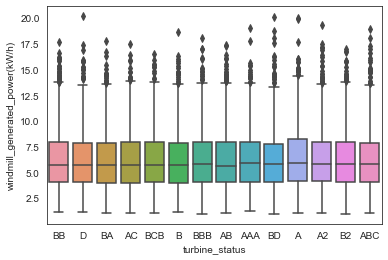

In [116]:
sns.boxplot(X_train['turbine_status'], y_train)

<AxesSubplot:xlabel='cloud_level', ylabel='windmill_generated_power(kW/h)'>

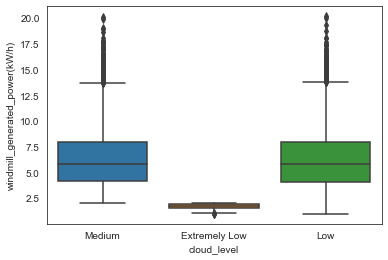

In [117]:
sns.boxplot(X_train['cloud_level'], y_train)

### Important variables we derived:
#### Numerical:
- wind_speed(m/s)
- haft_temperature(°C)
- blades_angle(°)
- gearbox_temperature(°C)
- engine_temperature(°C)
- motor_torque(N-m)
- generator_temperature(°C)
- area_temperature(°C)
- wind_direction(°)
- resistance(ohm)
- rotor_torque(N-m)
- blade_breadth(m)

#### Categorical
- cloud_level

# Encoding

In [118]:
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['turbine_status', 'cloud_level'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
20639,29.165222,4.441551,16.007962,-1.158862,116.522664,18.559412,881.213471,41.487133,116942.259539,25.369996,11.626132,280.130198,1340.359899,14.684567,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4.546609,0.432503,24.812621,1,0
505,94.767684,18.081439,43.793750,86.947450,41.008143,41.297332,1004.433697,66.353153,16311.985415,29.326023,-99.000000,374.388573,1663.337042,25.834748,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.244555,0.237205,16.311905,0,0
18039,39.097877,8.921827,46.758274,-99.000000,46.641045,45.137630,957.009470,42.448288,129052.691467,32.356140,20.754016,342.613137,1427.354328,15.268205,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-99.000000,0.467374,24.622301,0,0
16785,18.387458,9.926404,45.314961,-1.133298,44.719208,42.654147,772.373345,39.778793,122655.688822,25.268513,40.085835,275.660822,1240.895255,14.519918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.455391,0.449980,26.400075,0,0
24401,94.476735,26.159988,11.460848,39.749659,-2.088118,44.298081,1117.198016,69.563057,16621.749862,30.321309,43.924408,306.648593,1663.405530,22.596888,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4.337868,0.437560,24.375441,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13210,-107.206822,14.190797,80.688395,-0.692205,137.459567,43.921804,929.826193,42.362351,118426.832893,32.415978,20.754016,232.455409,1420.695555,16.786307,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.385628,0.407371,26.490003,1,0
19784,94.146353,17.551073,45.146921,9.648162,48.821965,45.241926,2802.511942,92.887576,18847.194888,39.858219,43.560988,499.761898,1975.706079,47.059900,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2.357959,0.335699,27.043789,0,0
9910,41.308615,11.860592,45.693220,11.938051,49.468022,42.891585,934.817779,47.127975,141413.343409,36.924496,45.172467,516.914848,1465.555896,18.252104,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2.348490,0.445592,25.164745,1,0
10869,95.722664,26.078089,41.864851,38.798129,39.429732,42.490011,1141.501484,66.925160,16402.040513,33.423691,45.294931,106.899949,1663.606364,-53.173383,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,3.816595,0.383892,25.358264,0,0


In [119]:
X_train.shape, X_test.shape

((27713, 36), (280, 36))

# Feature Scaling

In [120]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [121]:
X_train

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,-0.865787,-0.436489,-6.857725,-0.096096,13.800313,-7.664069,-0.722991,-0.774817,0.986706,-0.662311,-1.309495,-0.116527,-0.602784,-0.613861,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.783077,0.332558,-0.364353,1.0,0.0
1,0.020467,0.176744,0.027299,13.344642,-0.416144,-0.683829,-0.645512,-0.115592,-0.024435,-0.299037,-6.003177,0.996239,-0.026608,-0.208051,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-0.420532,-1.582649,-3.214662,0.0,0.0
2,-0.731602,-0.235061,0.761876,-15.021895,0.644313,0.495091,-0.675332,-0.749335,1.108392,-0.020788,-0.922214,0.621114,-0.447590,-0.592620,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-53.355353,0.674519,-0.428168,0.0,0.0
3,-1.011388,-0.189896,0.404239,-0.092196,0.282506,-0.267305,-0.791428,-0.820107,1.044115,-0.671630,-0.101998,-0.169290,-0.780225,-0.619854,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.212543,0.503948,0.167924,0.0,0.0
4,0.016536,0.539946,-7.984452,6.144555,-8.529500,0.237361,-0.574608,-0.030494,-0.021322,-0.207642,0.060867,0.196535,-0.026486,-0.325893,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.673938,0.382141,-0.510941,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27708,-2.708099,0.001826,9.169400,-0.024907,17.741920,0.121849,-0.692424,-0.751614,1.001623,-0.015293,-0.922214,-0.679351,-0.459469,-0.537369,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.176068,0.086093,0.198077,1.0,0.0
27709,0.012073,0.152900,0.362600,1.552530,1.054896,0.527109,0.485088,0.587864,0.001039,0.668112,0.045447,2.476332,0.530644,0.564437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0,-0.361240,-0.616757,0.383763,0.0,0.0
27710,-0.701736,-0.102938,0.497967,1.901856,1.176523,-0.194415,-0.689286,-0.625272,1.232593,0.398715,0.113820,2.678831,-0.379441,-0.484021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,-0.366190,0.460915,-0.246285,1.0,0.0
27711,0.033368,0.536264,-0.450662,5.999397,-0.713298,-0.317693,-0.559326,-0.100427,-0.023530,0.077243,0.119016,-2.161594,-0.026128,-3.083547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0,0.401395,-0.144149,-0.181398,0.0,0.0


# XGB

In [123]:
from sklearn.model_selection import ShuffleSplit, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.metrics import accuracy_score, r2_score
import xgboost as xgb
xgb =  xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5,
                       learning_rate = 0.03 , max_depth = 8, n_estimators = 500)

In [124]:
# fit the model
xgb.fit(X_train, y_train)

# Predict the Test set results
y_pred = xgb.predict(X_test)

In [125]:
from sklearn.metrics import accuracy_score, r2_score

# rf.score(X_test, y_test)
score = max(0, 100 * r2_score(y_test, y_pred))
score

92.53691684381909

# Test with test.csv

In [126]:
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,NaN,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,NaN,23.886434,13.501595,NaN,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,NaN,Medium,3.286975,0.407771,20.888674
12082,WM_1630,2018-11-12 17:33:20,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,NaN,0.367823,24.793606
12083,WM_24703,2019-05-27 11:53:20,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451
12084,WM_22893,2019-05-13 21:53:20,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,NaN,A,Medium,2.247676,0.394680,24.591364


In [127]:
test.isnull().sum()

tracking_id                         0
datetime                            0
wind_speed(m/s)                   126
atmospheric_temperature(°C)      1427
shaft_temperature(°C)               1
blades_angle(°)                   106
gearbox_temperature(°C)             1
engine_temperature(°C)              5
motor_torque(N-m)                  11
generator_temperature(°C)           5
atmospheric_pressure(Pascal)     1151
area_temperature(°C)                1
windmill_body_temperature(°C)     926
wind_direction(°)                2160
resistance(ohm)                     0
rotor_torque(N-m)                 281
turbine_status                    797
cloud_level                       125
blade_length(m)                  2114
blade_breadth(m)                    0
windmill_height(m)                255
dtype: int64

In [128]:
for c in ['turbine_status','cloud_level']:
    impute_categorical(test, c)

In [129]:
for i in test.columns:
    if test[i].isnull().sum()>0:
        mean = test[i].mean()
        test[i].replace(np.nan, mean, inplace=True)
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431,0,0
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,54283.324683,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823,0,0
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677,0,0
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,54283.324683,23.886434,13.501595,308.376140,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426,0,0
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1,0
12082,WM_1630,2018-11-12 17:33:20,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,2.201328,0.367823,24.793606,0,0
12083,WM_24703,2019-05-27 11:53:20,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,0,0
12084,WM_22893,2019-05-13 21:53:20,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,26.566581,A,Medium,2.247676,0.394680,24.591364,0,0


In [130]:
# X_train_final = train.drop([wind, 'tracking_id', 'datetime'], axis=1)
X_train_final = train3.drop([wind], axis=1)
y_train_final = train3[wind]
X_test_final = test.drop(['tracking_id', 'datetime'], axis=1)


X_train_final.shape, X_test_final.shape

((27993, 21), (12086, 21))

In [131]:
X_test_final

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431,0,0
1,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,54283.324683,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823,0,0
2,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677,0,0
3,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,54283.324683,23.886434,13.501595,308.376140,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426,0,0
4,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1,0
12082,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,2.201328,0.367823,24.793606,0,0
12083,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,0,0
12084,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,26.566581,A,Medium,2.247676,0.394680,24.591364,0,0


In [132]:
X_train_final = encoder.fit_transform(X_train_final)
X_test_final = encoder.transform(X_test_final)
X_train_final

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,29.165222,4.441551,16.007962,-1.158862,116.522664,18.559412,881.213471,41.487133,116942.259539,25.369996,11.626132,280.130198,1340.359899,14.684567,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4.546609,0.432503,24.812621,1,0
1,94.767684,18.081439,43.793750,86.947450,41.008143,41.297332,1004.433697,66.353153,16311.985415,29.326023,-99.000000,374.388573,1663.337042,25.834748,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.244555,0.237205,16.311905,0,0
2,39.097877,8.921827,46.758274,-99.000000,46.641045,45.137630,957.009470,42.448288,129052.691467,32.356140,20.754016,342.613137,1427.354328,15.268205,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-99.000000,0.467374,24.622301,0,0
3,18.387458,9.926404,45.314961,-1.133298,44.719208,42.654147,772.373345,39.778793,122655.688822,25.268513,40.085835,275.660822,1240.895255,14.519918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.455391,0.449980,26.400075,0,0
4,94.476735,26.159988,11.460848,39.749659,-2.088118,44.298081,1117.198016,69.563057,16621.749862,30.321309,43.924408,306.648593,1663.405530,22.596888,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4.337868,0.437560,24.375441,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27988,205.877463,-99.000000,42.531312,40.968971,41.649804,42.760867,526.074933,37.237309,114030.753556,28.213448,44.359178,225.944824,1163.440984,-115.027862,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3.794529,0.422523,27.751522,0,0
27989,93.643656,33.617309,44.013938,0.762278,96.679473,41.453165,2147.446711,70.476839,17116.015118,39.558442,43.008021,276.515502,1694.718170,35.347647,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2.211411,0.308142,25.564309,0,0
27990,380.229029,11.722376,43.053466,1.296582,44.788704,44.095178,756.766063,44.522909,77291.728212,29.924312,41.201989,55.865086,1188.992564,12.233934,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,4.139110,0.467881,26.306664,0,0
27991,-54.252314,18.640625,41.057651,21.337316,87.649093,42.133972,1531.646898,70.317959,16963.206456,30.778969,41.406119,260.133656,1666.794453,27.841929,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4.332921,0.361095,25.050941,0,0


In [133]:
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

X_train_final= pd.DataFrame(X_train_final, columns=[cols])
X_test_final = pd.DataFrame(X_test_final, columns=[cols])

In [134]:
xgb.fit(X_train_final, y_train_final)

# Predict the Test set results
y_pred_final = xgb.predict(X_test_final)
y_pred_final

array([ 2.6044724,  2.3948421,  3.1894336, ...,  5.1423106,  5.3569455,
       10.906695 ], dtype=float32)

In [135]:
y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
y_pred_final_df

,windmill_generated_power(kW/h)
0,2.604472
1,2.394842
2,3.189434
3,7.425407
4,3.577913
...,...
12081,6.680641
12082,3.301696
12083,5.142311
12084,5.356946


In [136]:
submission = pd.concat([test[['tracking_id', 'datetime']], y_pred_final_df], axis=1)
submission.isnull().sum()

tracking_id                       0
datetime                          0
windmill_generated_power(kW/h)    0
dtype: int64

In [137]:
submission.shape

(12086, 3)

In [138]:
submission.to_csv('submissions/submission_xgb_extended2.5(fillna after split).csv', index=False)

### More tests

In [139]:
imp0 = ['wind_speed(m/s)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'generator_temperature(°C)',
 'area_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'blade_breadth(m)', 'cloud_level']

imp = ['motor_torque(N-m)', 'blades_angle(°)', 'atmospheric_pressure(Pascal)', 'resistance(ohm)', 'generator_temperature(°C)', 'engine_temperature(°C)']

In [145]:
from sklearn.model_selection import train_test_split
X = train3[imp0]
y = train3[wind]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 0)

X_train.shape, X_test.shape

# Encoding
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['cloud_level'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = RobustScaler()

cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])


# fit the model
xgb.fit(X_train, y_train)

# Predict the Test set results
y_pred = xgb.predict(X_test)

score = max(0, 100 * r2_score(y_test, y_pred))
score

97.32371643628267

In [146]:
X_train_final = train3[imp0]
y_train_final = train3[wind]
X_test_final = test[imp0]

X_train_final = encoder.fit_transform(X_train_final)
X_test_final = encoder.transform(X_test_final)

X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

X_train_final= pd.DataFrame(X_train_final, columns=[cols])
X_test_final = pd.DataFrame(X_test_final, columns=[cols])

xgb.fit(X_train_final, y_train_final)

# Predict the Test set results
y_pred_final = xgb.predict(X_test_final)

y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
y_pred_final_df

submission = pd.concat([test[['tracking_id', 'datetime']], y_pred_final_df], axis=1)

submission.to_csv('submissions/submission_xgb_extended2.6(fillna after split).csv', index=False)